# Walmart Forecasting with SARIMAX & XGBoost Models
By: Robert Russ

### Problem

The Walmart sales data is a hiearchical form of time series data.  I will start with a simplier and classical statistical model (SARIMAX) first then use more modern machine learning models to forecast the time series data for 28 days.  SARIMAX stands for Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors.  I will focus mainly on the ARIMA component.  All of the helper functions and classes used in this notebook come from https://mlcourse.ai/.  

References:

Kashnitsky, Y., (2019). Topic 9. Part 1. Time series analysis in Python. Retrieved from: https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

Kashnitsky, Y. (2020). Retrieved from: https://mlcourse.ai/   

Lima, R. (2020). Time Series Analysis - ES+SARIMAX+XGB+LGBM. Retrieved from: https://www.kaggle.com/rodrigolima82/time-series-analysis-es-sarimax-xgb-lgbm  

### Loading the libraries

In [1]:
import pandas as pd
import numpy as np

from itertools import product
from multiprocessing import Pool
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize
import scipy.stats as scs
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import datetime
from dateutil.relativedelta import relativedelta
import time
import gc
import os
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings (action = "ignore")

# Set some options in Jupyter to display datasets.
pd.set_option ('display.max_columns', 200)
pd.set_option ('display.max_rows', 200)

# Variable to control Kaggle training.
TRAIN_OFFLINE = False

# Variable to indicate the local path.
LOCAL_DATA_FOLDER  = 'data/'
KAGGLE_DATA_FOLDER = '/kaggle/input/m5-forecasting-accuracy/'

In [2]:
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

import xgboost as xgb

### Importing the data

In [3]:
# Function for reducing the used memory.
def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[: 3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df [col] = df [col] .astype (np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df [col] = df [col] .astype (np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {: 5.2f} Mb ({: .1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Function for reading LOCAL or KAGGLE files.
def read_data():
    
    # If local.
    if TRAIN_OFFLINE:

        calendar = pd.read_csv('calendar.csv')
        sell_prices = pd.read_csv('sell_prices.csv')
        sales_train_validation = pd.read_csv('sales_train_validation.csv')
        submission = pd.read_csv('sample_submission.csv')

    # If you are in the Kaggle environment.
    else:
        
        calendar = pd.read_csv('calendar.csv')
        sell_prices = pd.read_csv('sell_prices.csv')
        sales_train_validation = pd.read_csv('sales_train_validation.csv')
        submission = pd.read_csv('sample_submission.csv')

    calendar = reduce_mem_usage(calendar)
    sell_prices = reduce_mem_usage(sell_prices)
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    submission = reduce_mem_usage(submission)
        
    return calendar, sell_prices, sales_train_validation, submission

In [4]:
# Reading the data and applying memory reduction.
calendar, sell_prices, sales_train_validation, submission = read_data()

Mem. usage decreased to  0.12 Mb ( 41.9% reduction)
Mem. usage decreased to  130.48 Mb ( 37.5% reduction)
Mem. usage decreased to  95.00 Mb ( 78.7% reduction)
Mem. usage decreased to  2.09 Mb ( 84.5% reduction)


### Feature Engineering

In [5]:
# Function to merge datasets returning only one dataframe.
def reshape_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 30000000, merge = False):
    
    # Reshaping sales data using melt.
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print ('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_trian_validation = reduce_mem_usage(sales_train_validation)
    
    # Preparing test and validation records.
    test_rows = [row for row in submission['id'] if 'validation' in row]
    val_rows = [row for row in submission['id'] if 'evaluation' in row]
    
    test = submission[submission ['id']. isin(test_rows)]
    val = submission[submission ['id']. isin(val_rows)]
    
    # Renaming the columns.
    test.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921',
                    'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930',
                    'd_1931', 'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939',
                    'd_1940', 'd_1941']
    val.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949',
                   'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958',
                   'd_1959', 'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967',
                   'd_1968', 'd_1969']
    
    # Getting only product data and removing duplicate records.
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]. drop_duplicates ()
    
    # Merge with the product table.
    test = test.merge(product, how = 'left', on = 'id')
    val = val.merge(product, how = 'left', on = 'id')
    
    # Reshaping test and validation data.
    test = pd.melt(test, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    val = pd.melt(val, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    # Creating a new column to define training, test and validation data.
    sales_train_validation['part'] = 'train'
    test['part'] = 'test'
    val['part'] = 'val'
    
    # Creating a single dataset with the addition of all training, validation and test records.
    data = pd.concat([sales_train_validation, test, val], axis = 0)
    
    # Removing previous datasets.
    del sales_train_validation, test, val
    
    # Selecting only a few records for training.
    data = data.loc[nrows:]
    
    # Removing validation data.
    data = data[data ['part']!= 'val']
    
    # Performing the merge with calendar and price.
    if merge:
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day', 'weekday'], inplace = True, axis = 1)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Final dataset for training has {} rows and {} columns'.format(data.shape [0], data.shape [1]))
    else:
        pass
    
    return data

# Function for handling missing values and transformation of categorical/numeric features
def transform(data):
    
    # Performing treatment on missing values for the categorical features.
    nan_features_cat = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features_cat:
        data[feature] .fillna('unknown', inplace = True)
    
    # Performing treatment on missing values for the sell_price feature.
    data['sell_price']. fillna(0, inplace = True)
        
    # Turning features categories into numbers to make predictions.
    encoder = preprocessing.LabelEncoder ()
    data['id_encode'] = encoder.fit_transform(data ['id'])
    
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
           'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

In [6]:
%%time

# Reshaping and merging datasets.
data = reshape_and_merge(calendar, sell_prices, sales_train_validation, submission, merge = True)

# Calling up the data transformation functions.
data = transform(data)

# Viewing the final dataset header.
data.head()

# Clearing data from memory.
gc.collect()

Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to  3226.27 Mb ( 0.0% reduction)
Final dataset for training has 29181090 rows and 21 columns
Wall time: 5min 54s


In [7]:
# Checking the start and end date of the dataset.
print(min(data['date']), max(data['date']))

1/1/2014 9/9/2015


### Time Series in Python

- Methods and models that we can use for predictions in this dataset.
- Apply double and triple exponential smoothing.
- Analyze stationarity.
- Create SARIMA model.
- Make predictions using xgboost.

#### Check the feature engineering and transformations.

In [8]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
0,HOUSEHOLD_1_331_WI_3_validation,2326,5,2,9,2,0,train,10/8/2013,11337,4,10,2013,30,4,2,2,1,0,1,4.878906,23269
1,HOUSEHOLD_1_332_WI_3_validation,2327,5,2,9,2,0,train,10/8/2013,11337,4,10,2013,30,4,2,2,1,0,1,0.000000,23279
2,HOUSEHOLD_1_333_WI_3_validation,2328,5,2,9,2,0,train,10/8/2013,11337,4,10,2013,30,4,2,2,1,0,1,2.970703,23289
3,HOUSEHOLD_1_334_WI_3_validation,2329,5,2,9,2,11,train,10/8/2013,11337,4,10,2013,30,4,2,2,1,0,1,0.979980,23299
4,HOUSEHOLD_1_335_WI_3_validation,2330,5,2,9,2,0,train,10/8/2013,11337,4,10,2013,30,4,2,2,1,0,1,8.968750,23309
5,HOUSEHOLD_1_336_WI_3_validation,2331,5,2,9,2,1,train,10/8/2013,11337,4,10,2013,30,4,2,2,1,0,1,4.871094,23319
6,HOUSEHOLD_1_337_WI_3_validation,2332,5,2,9,2,0,train,10/8/2013,11337,4,10,2013,30,4,2,2,1,0,1,4.968750,23329
7,HOUSEHOLD_1_338_WI_3_validation,2333,5,2,9,2,1,train,10/8/2013,11337,4,10,2013,30,4,2,2,1,0,1,3.980469,23339
8,HOUSEHOLD_1_339_WI_3_validation,2334,5,2,9,2,9,train,10/8/2013,11337,4,10,2013,30,4,2,2,1,0,1,0.979980,23349
9,HOUSEHOLD_1_340_WI_3_validation,2335,5,2,9,2,0,train,10/8/2013,11337,4,10,2013,30,4,2,2,1,0,1,4.980469,23359


In [9]:
data[data['id'] == 'FOODS_3_634_WI_2_validation'].head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
29410,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,10/9/2013,11337,5,10,2013,30,4,2,2,1,1,1,3.980469,12468
59900,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,10/10/2013,11337,6,10,2013,30,4,2,2,1,0,0,3.980469,12468
90390,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,10/11/2013,11337,7,10,2013,30,4,2,2,0,1,1,3.980469,12468
120880,FOODS_3_634_WI_2_validation,1246,2,0,8,2,13,train,10/12/2013,11338,1,10,2013,30,4,2,2,0,1,1,3.980469,12468
151370,FOODS_3_634_WI_2_validation,1246,2,0,8,2,10,train,10/13/2013,11338,2,10,2013,30,4,2,2,0,1,0,3.980469,12468


In [10]:
data[(data['id'] == 'FOODS_3_634_WI_2_validation') & (data['demand'] > 0) & (data['part'] == 'train')]

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,id_encode
29410,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,10/9/2013,11337,5,10,2013,30,4,2,2,1,1,1,3.980469,12468
59900,FOODS_3_634_WI_2_validation,1246,2,0,8,2,5,train,10/10/2013,11337,6,10,2013,30,4,2,2,1,0,0,3.980469,12468
90390,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,10/11/2013,11337,7,10,2013,30,4,2,2,0,1,1,3.980469,12468
120880,FOODS_3_634_WI_2_validation,1246,2,0,8,2,13,train,10/12/2013,11338,1,10,2013,30,4,2,2,0,1,1,3.980469,12468
151370,FOODS_3_634_WI_2_validation,1246,2,0,8,2,10,train,10/13/2013,11338,2,10,2013,30,4,2,2,0,1,0,3.980469,12468
181860,FOODS_3_634_WI_2_validation,1246,2,0,8,2,7,train,10/14/2013,11338,3,10,2013,3,1,2,2,0,0,1,3.980469,12468
212350,FOODS_3_634_WI_2_validation,1246,2,0,8,2,7,train,10/15/2013,11338,4,10,2013,6,2,2,2,0,1,1,3.980469,12468
242840,FOODS_3_634_WI_2_validation,1246,2,0,8,2,4,train,10/16/2013,11338,5,10,2013,30,4,2,2,0,0,0,3.980469,12468
273330,FOODS_3_634_WI_2_validation,1246,2,0,8,2,3,train,10/17/2013,11338,6,10,2013,30,4,2,2,0,0,0,3.980469,12468
303820,FOODS_3_634_WI_2_validation,1246,2,0,8,2,8,train,10/18/2013,11338,7,10,2013,30,4,2,2,0,0,0,3.980469,12468


#### Selecting Training and Validation Data

In [11]:
# Selecting only 1 item for testing: FOODS_3_634_WI_2.
df = data [(data ['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_3_634_WI_2_validation') & (data ['demand'] > 0) & (data['demand'] <= 15)]

# Selecting only a few columns for analysis and training.
df = df[['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]

# Transforming the date as index.
df = df.set_index('date')

# Viewing the dataset result.
df.head()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
10/9/2013,8,2,0,8,2,30,4,1,3.980469
10/10/2013,5,2,0,8,2,30,4,0,3.980469
10/11/2013,8,2,0,8,2,30,4,1,3.980469
10/12/2013,13,2,0,8,2,30,4,1,3.980469
10/13/2013,10,2,0,8,2,30,4,0,3.980469


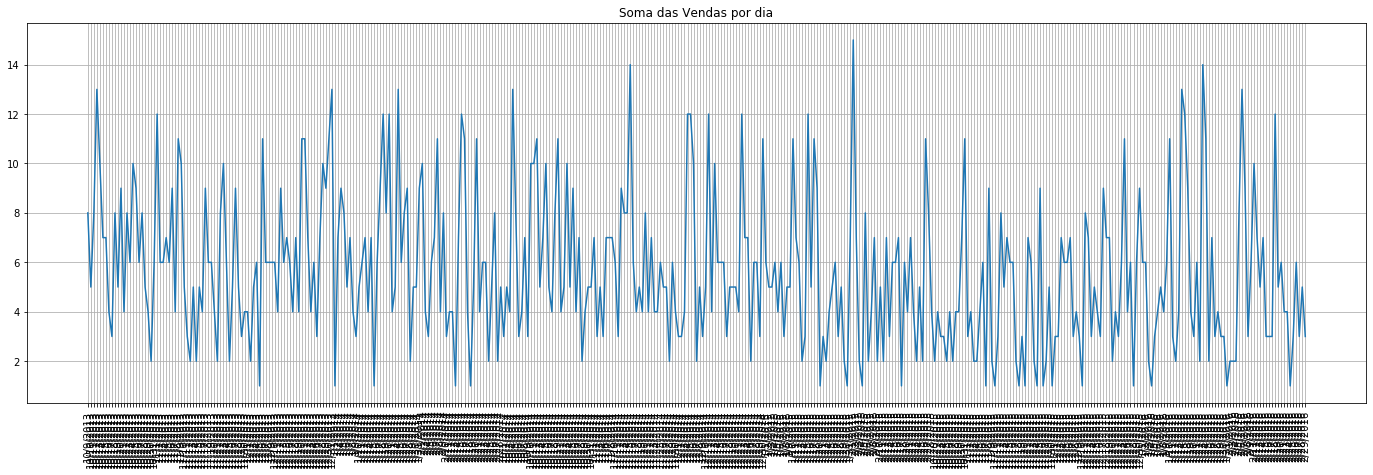

In [12]:
# Display the sum of sales per day.
plt.figure(figsize=(24, 7))
plt.plot(df['demand'])
plt.title('Sum of Sales per Day')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

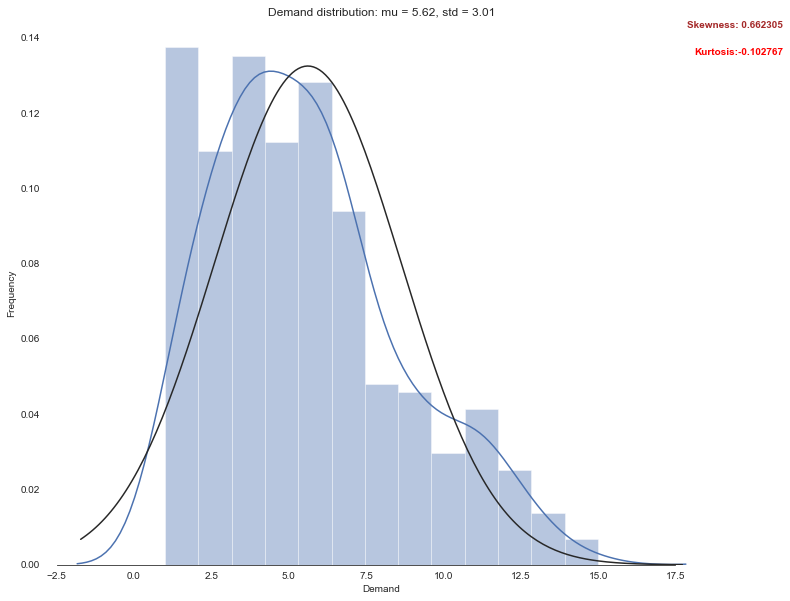

In [13]:
# Viewing distribution information for the variable "demand".
sns.set_style("white")
sns.set_color_codes(palette = 'deep')
f, ax = plt.subplots(figsize = (12, 8))

# Fit a normal distribution.
mu, std = norm.fit(df['demand'])

# Checking the frequency distribution of the variable "demand".
sns.distplot (df['demand'], color = "b", fit = stats.norm)
ax.xaxis.grid(False)
ax.set(ylabel = "Frequency")
ax.set(xlabel = "Demand")
ax.set(title = "Demand distribution: mu =% .2f, std =% .2f"% (mu, std))
sns.despine(trim = True, left = True)

# Adding Skewness and Kurtosis.
ax.text(x = 1.1, y = 1, transform = ax.transAxes, s = "Skewness:% f"% df ['demand']. skew (), \
        fontweight = 'demibold', fontsize = 10, verticalalignment = 'top', horizontalalignment = 'right', \
        backgroundcolor = 'white', color = 'blue')
ax.text(x = 1.1, y = 0.95, transform = ax.transAxes, s = "Kurtosis:% f"% df ['demand']. kurt (), \
        fontweight = 'demibold', fontsize = 10, verticalalignment = 'top', horizontalalignment = 'right', \
        backgroundcolor = 'white', color = 'red')

plt.show()

### Metrics for forecasting

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Move, smooth, and evaluate the time series

I will start with an assumption for the time series forecast values that "tomorrow will be the same as today", but this assumption does not account for the variablity in previous values.  This is why I will need to use another assumption that states " ... the future value of our variable depends on the average of the previous values."  Thus, I will use the moving average for the future values.

In [15]:
def moving_average(series, n):
    """
        Calculate average of last n observations.
    """
    return np.average(series[-n:])

#  Making predictions for the last 28 days.
moving_average(df, 28)

5.974020337301587

I cannot use moving average to make prediction; instead, I will use it to smoothen out the data to find trends.  Pandas has way to do this documented here: [`DataFrame.rolling (window) .mean ()`] (http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html).

In [16]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values.
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values.
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

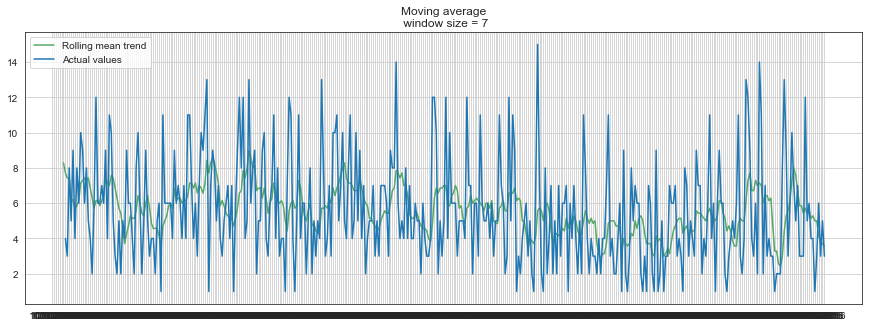

In [17]:
# Smooth out data using a 7-day window.
plotMovingAverage (df ['demand'], 7)

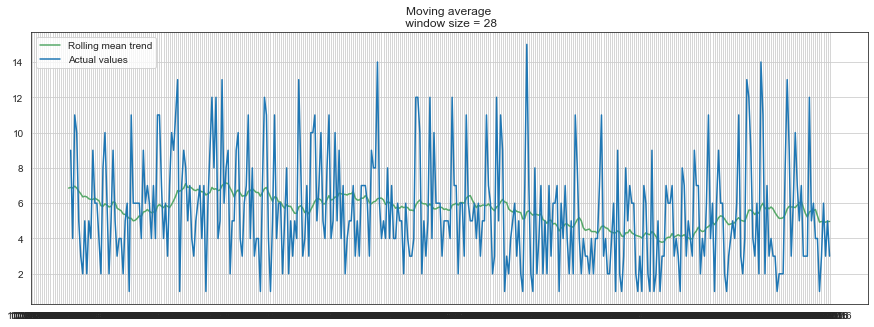

In [18]:
# Smooth out using a 28-day window.
plotMovingAverage (df ['demand'], 28)

The window with 28 days is smoother than window with 7 days because the larger the window the smoother the time series.  This enables me to clearly see the sales trend in each period.  I can us confidence intervals to give more information about the sales trends.

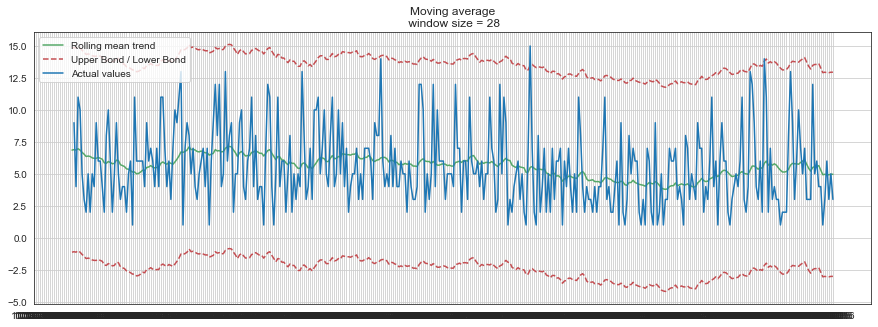

In [19]:
plotMovingAverage(df['demand'], 28, plot_intervals=True)

Based on the charts above, I can see the data has seasonality because there are places in the time series were the chart decreases and then increases quickly.

I will use a weighted average because it accounts for the relative importance of each number in the average and assigns weights to the numbers, as opposed to a simple average accounts for each number to have an equal weight.  The weighted average is more accurate.

In [20]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [21]:
weighted_average(df['demand'], [0.6, 0.3, 0.1])

3.5999999999999996

### Single, Double, and Triple Exponential Smoothing

I previously use moving averages to smoothen the data.  Now, I want to look at the different method called exponential smoothing.  This method uses exponential window functions to smoothen the data.  This method uses exponential decreasing functions to assign weights.  This accounts for assumptions such as seasonality.     (https://en.wikipedia.org/wiki/Exponential_smoothing)

In [22]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    # First value is same as series.
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [23]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

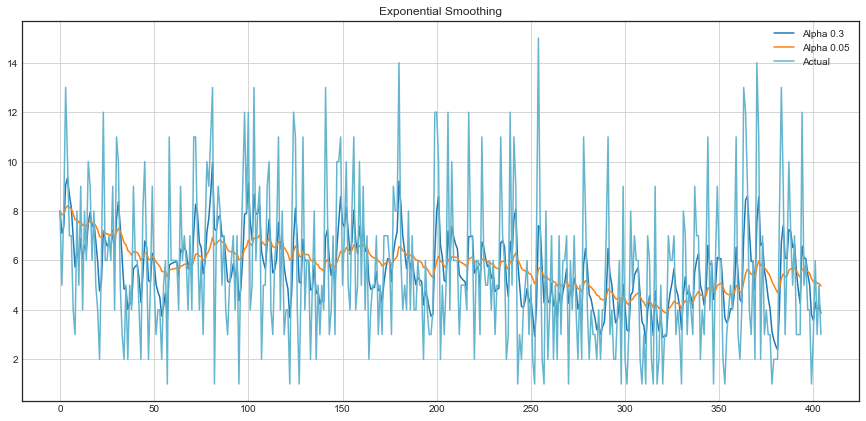

In [24]:
plotExponentialSmoothing(df['demand'], [0.3, 0.05])

In [25]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # First value is same as series.
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [26]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

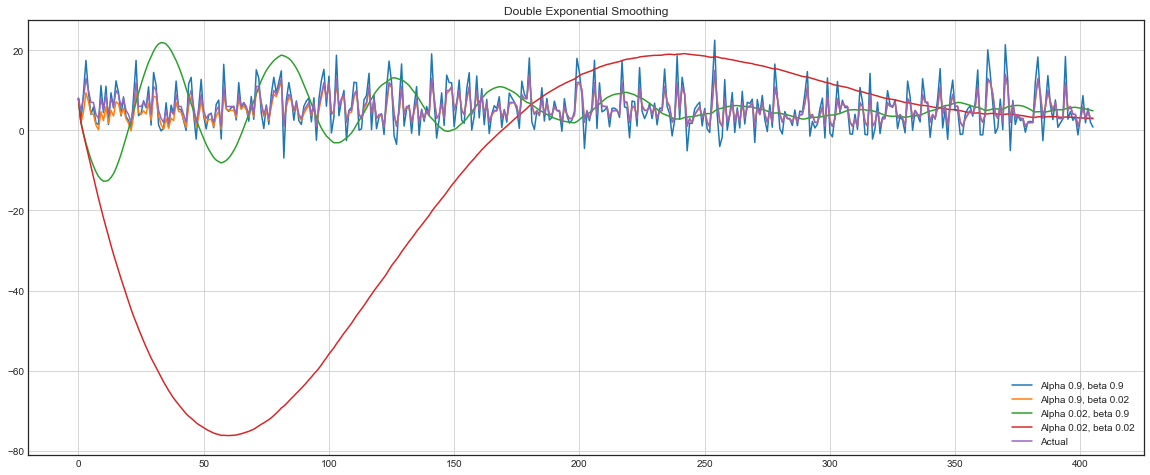

In [27]:
plotDoubleExponentialSmoothing(df['demand'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

Now, I have to adjust two parameters: alpha and beta. The alpha is responsible for smoothing the series around the trend, and beta is responsible for smoothing the trend itself.  The higher the values, the greater the weight of the most recent observations and the less smooth the series will be.

### Triple Exponential Smoothing (Holt-Winters)

I looked at the single and double exponential smoothing methods.  Now, I want to introduce a third component which is seasonality.  I am using this method because I observed earlier there is seasonality in this time series.  Holt-Winters technique should not be used if I do not expect seasonality in the data.  I will alos use the Brutlag method to get the confidence intervals to detect anomalies in the time series.  

In [28]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method.
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor = 1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series [i + self.slen] - self.series [i]) / self.slen
        return sum / self.slen
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int (len(self.series) / self.slen)
        # Calculate season averages.
        for j in range(n_seasons):
            season_averages.append(sum (self.series[self.slen * j: self.slen * j + self.slen]) / float(self.slen))
        # Calculate initial values.
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series) + self.n_preds):
            if i == 0: 
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i% self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result [0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation [0])
                continue
                
            if i >= len(self.series):
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals [i % self.slen])
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val-seasonals[i % self.slen]) + (1-self.alpha) * (smooth + trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta) * trend
                seasonals [i % self.slen] = self.gamma * (val-smooth) + (1-self.gamma) * seasonals [i % self.slen]
                self.result.append(smooth + trend + seasonals [i % self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series [i] - self.result [i])
                                               + (1-self.gamma) * self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals [i % self.slen])

### Time Series Cross Validation

Cross validation is done differently with time series data because of the time structure of the data.  I cannot just use randomization to get the data for each sample for the folds in cross validation.  Instead, we use the following ideas:  

I train a model on a small segment of the time series from the beginning to tt, made predictions for the next steps of t + nt + n and calculated an error. Next, I expand the training sample to the value t + nt + n, make predictions from t + nt + n to t + 2 ∗ nt + 2 ∗ n and continue moving the time series test window until I reach the last available observation. As a result, I have many samples nn between the initial training sample and the last observation.  The graphic illustrates cross validation with time series well.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Retrieved from: https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png

In [29]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=28):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=2) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], 
                            slen=slen, 
                            alpha=alpha, 
                            beta=beta, 
                            gamma=gamma, 
                            n_preds=len(test))
        
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [30]:
%%time

new_data = df['demand']

# Initializing model parameters alpha, beta and gamma.
x = [0, 0, 0] 

# Minimizing the loss function. 
opt = minimize(timeseriesCVscore, 
               x0=x, 
               args=(new_data, mean_squared_error), 
               method="TNC", 
               bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values.
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# Train the model with them, forecasting for the next 28 days.
model = HoltWinters(new_data, 
                    slen = 28, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 28, 
                    scaling_factor = 3)

model.triple_exponential_smoothing()

0.012935494297423578 0.03284570320213853 0.1375372444399972
Wall time: 10.3 s


The errors above a low, so this means the function found optimal parameter values.

In [31]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    
    error = rmse(series.values, model.result[:len(series)])
    plt.title("RMSE: {0:.2f}".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values > model.UpperBond[:len(series)]] = \
            series.values[series.values > model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-60, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

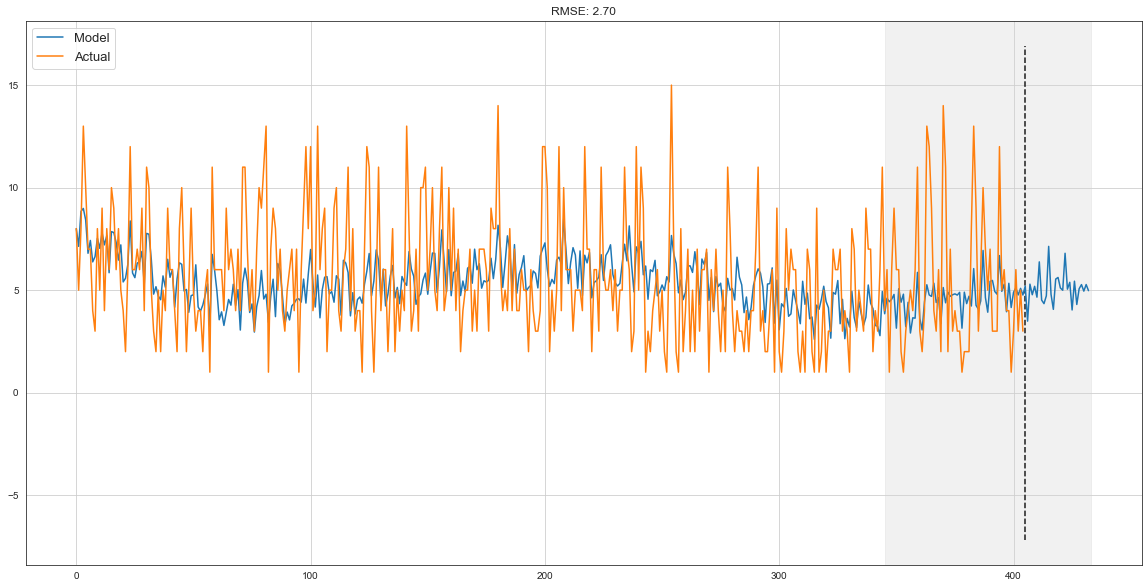

In [32]:
plotHoltWinters(df['demand'])

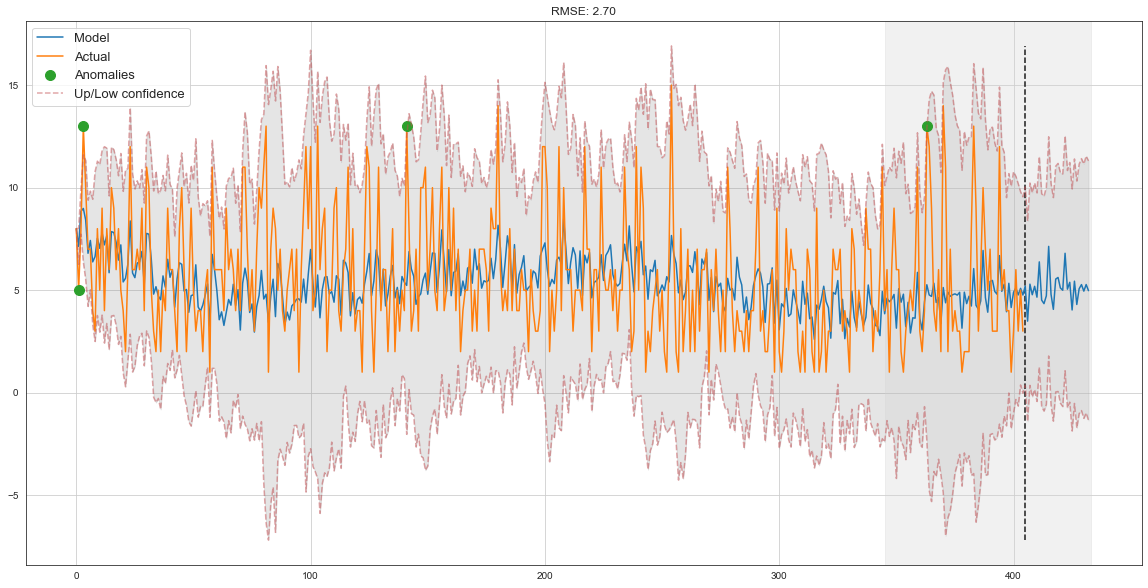

In [33]:
plotHoltWinters(df['demand'], plot_intervals=True, plot_anomalies=True)

Based on the graphs, I can see the model successfully estimated the time series, captured the seasonality and general decreasing trend, and even some anomalies.  If you look at the deviations from the model, you can see that the model reacts a lot to changes in the series structure, but then quickly returns the deviation to normal values, essentially "forgetting" the past. This model feature allows me to quickly create anomaly detection systems, even for noise in the series data, without spending a lot of time preparing the data and training the model.

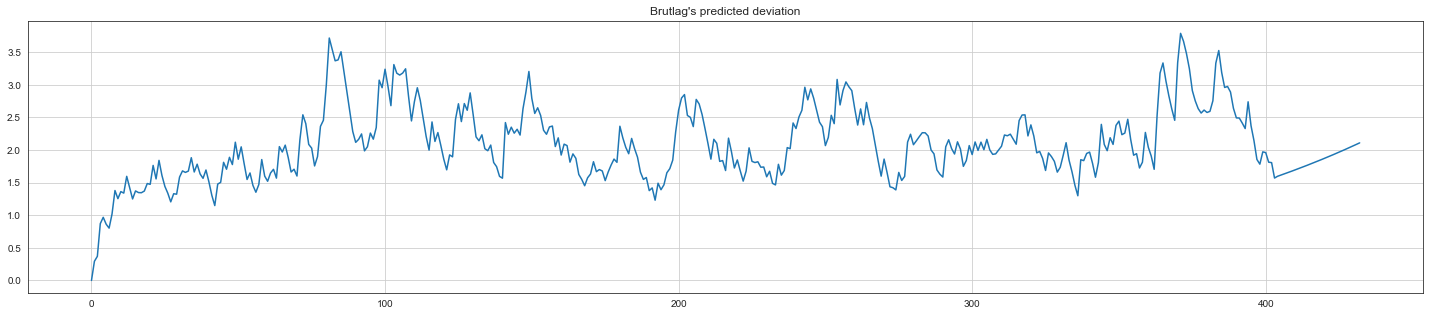

In [34]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

### Stationarity


Before starting, I must mention an important property of the time series which is stationarity.  If a process is stationary, it means that it does not change its statistical properties over time, that is, its mean and variance (https://en.wikipedia.org/wiki/Stationary_process).  The covariance function does not depend on time, it must depend only on the distance between observations. You can see these images from [Sean Abu]'s post (http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):

Stationary series is easier to make predictions.  Most time series models try to predict mean or vairations or other properties.  Future predictions would be wrong if the original series were not stationary.  I want to detect non-stationarity by analyzing the white noise and randow walks.

### Building a SARIMA Model

In [35]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test.
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

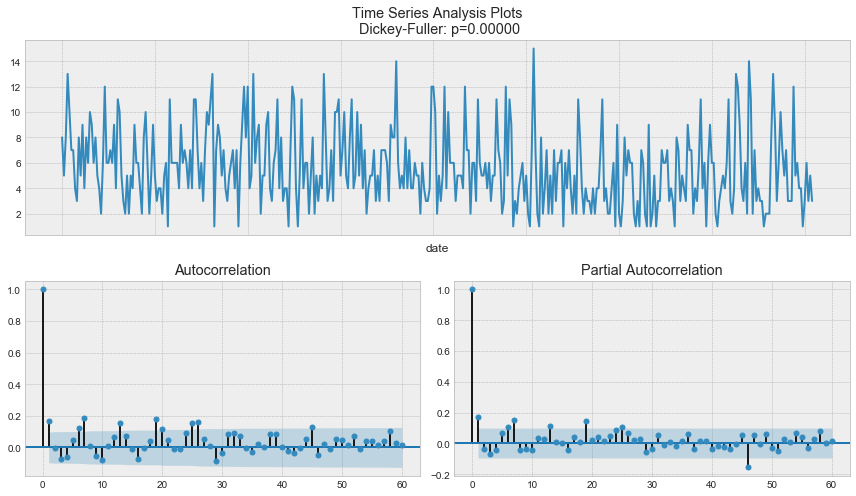

In [36]:
tsplot(df['demand'], lags=60)

According to the Dickey-Fuller test, the p-value is less than the level of significance of 0.05; therefore, I will reject the null hypothesis and say that a unit root is present.  This means the time series is stationary.  I will not have to correct for unstationary data.  

I know there is seasonality.  I will correct for this by taking the 'seasonal difference'.  This is done by simple subtraction of the series from itself with a delay equal to the seasonal period (https://otexts.com/fpp2/stationarity.html).  

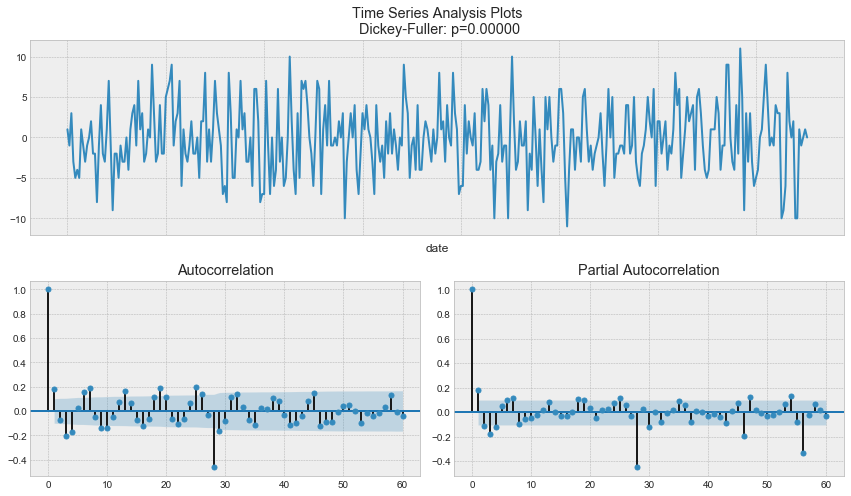

In [37]:
# Seasonal differencing.
df_diff = df['demand'] - df['demand'].shift(28)
tsplot(df_diff[28:], lags=60)

### SARIMA Model

SARIMA model is used because there is seasonality in the data, and I need to account for it in my forecast.

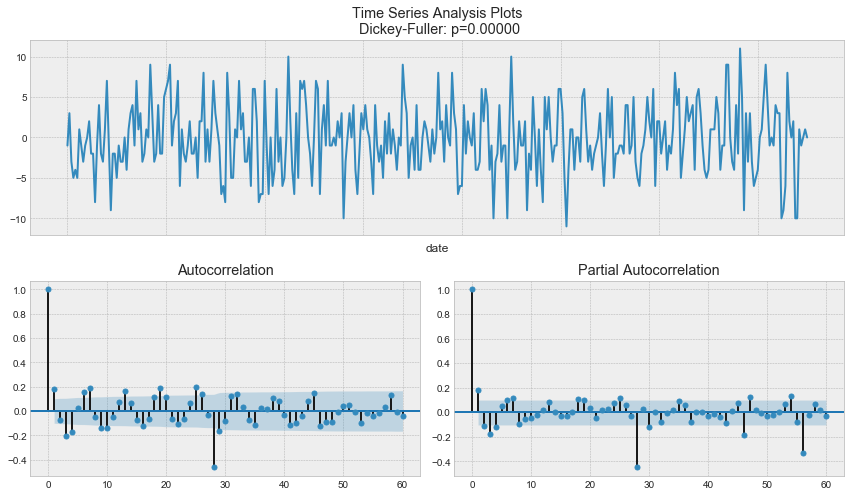

In [38]:
tsplot(df_diff[28+1:], lags=60)

In [45]:
# Setting initial values and some bounds.
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 28 # season length is still 28

# Creating list with all the possible combinations of parameters.
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [46]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC for the optimal model to use for forecasting.
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(df['demand'], 
                                            order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [47]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


Wall time: 8min 6s


In [48]:
result_table.head()

,parameters,aic
0,"(3, 4, 0, 1)",1949.411611
1,"(3, 4, 1, 1)",1949.582005
2,"(4, 4, 1, 1)",1951.267825
3,"(4, 4, 0, 1)",1951.420864
4,"(2, 3, 0, 1)",1951.959866


In [49]:
# Set the parameters that give the lowest AIC.
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df['demand'], 
                                     order=(p, d, q),
                                     seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             demand   No. Observations:                  405
Model:             SARIMAX(3, 1, 4)x(0, 1, 1, 28)   Log Likelihood                -965.706
Date:                            Fri, 24 Apr 2020   AIC                           1949.412
Time:                                    14:37:14   BIC                           1984.778
Sample:                                         0   HQIC                          1963.451
                                            - 405                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1327      0.043      3.104      0.002       0.049       0.217
ar.L2          0.0379      0.046   

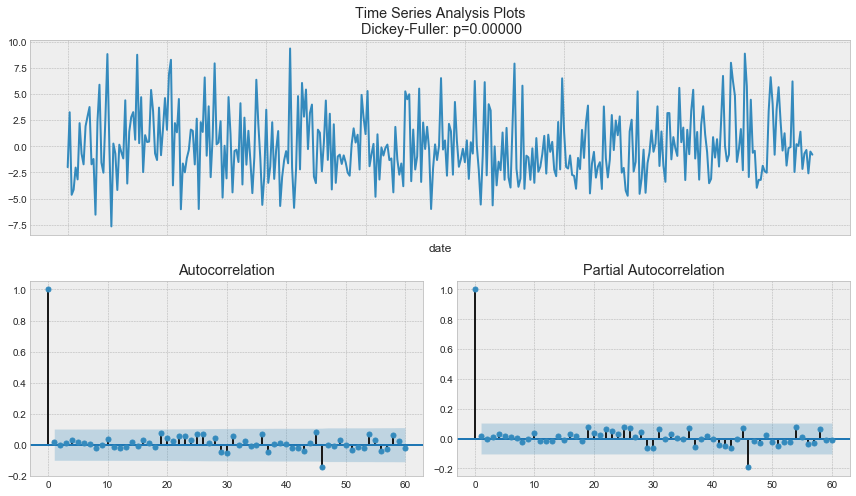

In [50]:
# Inspect the residues of the model.
tsplot(best_model.resid[28+1:], lags=60)

I can see clearly that the residues are stationary and not autocorrelation.  This means I can make predictions using this model.

In [51]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # Adding model values.
    dfCopy = series.copy()
    
    dfCopy['arima_model'] = model.fittedvalues
    dfCopy['arima_model'][:s+d] = np.NaN    
    
    # Forecasting on n_steps forward. 
    forecast = model.predict(start = dfCopy.shape[0], end = dfCopy.shape[0]+n_steps)
    forecast = dfCopy['arima_model'].append(forecast)

    # Calculate error.
    error = rmse(dfCopy['demand'][s+d:], dfCopy['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("RMSE: {0:.2f}".format(error))
    plt.plot(dfCopy['demand'], label="actual")
    plt.legend()
    plt.grid(True);

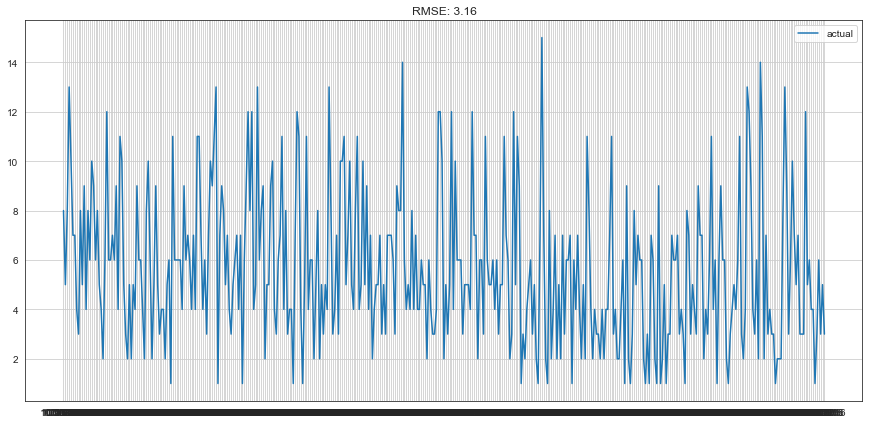

In [52]:
plotSARIMA(df, best_model, 28)

The model was off by 3.16 (RMSE), which is pretty good.  There is a lot of time investigating and preparing the data for this score.  This model is pretty unstable in production environment.  I would need to train the model often, and this makes automating the process difficult.  I will consider using Linear Regression and XGBoost machine learning model in this notebook which is more stable in a production environment.  I will need to preprocess, transform, and split the data before forecasting with these models.

### Feature Extraction

Features to extract from dataset:
- Lags of time series
- Window statistics such as max, min, average, median, variance values of a window.
- Date and time features such as special events, day of the week, month, year, holidays, etc
- Target encoding

### Time Series Lags

I will increase lags to 28 days which allow the forecast to predict 28 steps ahead and use 28 steps back.  In selecting the intial delay, I will need to find a balance in the optimal forecast quality and the forecast duration (mlcourse.ai).  

In [53]:
# Create a copy of the original dataset.
new_df = df.copy ()

# Viewing the dataset.
new_df.head ()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
10/9/2013,8,2,0,8,2,30,4,1,3.980469
10/10/2013,5,2,0,8,2,30,4,0,3.980469
10/11/2013,8,2,0,8,2,30,4,1,3.980469
10/12/2013,13,2,0,8,2,30,4,1,3.980469
10/13/2013,10,2,0,8,2,30,4,0,3.980469


In [54]:
# Adding features considering the demand delay of 7 to 28 days.
for i in range (7, 29):
     new_df ["lag _ {}". format (i)] = new_df ['demand']. shift (i)

In [55]:
# Viewing the dataset result.
new_df.tail ()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price,lag _ 7,lag _ 8,lag _ 9,lag _ 10,lag _ 11,lag _ 12,lag _ 13,lag _ 14,lag _ 15,lag _ 16,lag _ 17,lag _ 18,lag _ 19,lag _ 20,lag _ 21,lag _ 22,lag _ 23,lag _ 24,lag _ 25,lag _ 26,lag _ 27,lag _ 28
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2/25/2016,3,2,0,8,2,30,4,0,3.980469,3.0,3.0,3.0,7.0,5.0,7.0,10.0,6.0,3.0,9.0,13.0,8.0,2.0,2.0,2.0,1.0,3.0,3.0,4.0,3.0,7.0,2.0
2/26/2016,6,2,0,8,2,30,4,0,3.980469,12.0,3.0,3.0,3.0,7.0,5.0,7.0,10.0,6.0,3.0,9.0,13.0,8.0,2.0,2.0,2.0,1.0,3.0,3.0,4.0,3.0,7.0
2/27/2016,3,2,0,8,2,30,4,0,3.980469,5.0,12.0,3.0,3.0,3.0,7.0,5.0,7.0,10.0,6.0,3.0,9.0,13.0,8.0,2.0,2.0,2.0,1.0,3.0,3.0,4.0,3.0
2/28/2016,5,2,0,8,2,30,4,0,3.980469,6.0,5.0,12.0,3.0,3.0,3.0,7.0,5.0,7.0,10.0,6.0,3.0,9.0,13.0,8.0,2.0,2.0,2.0,1.0,3.0,3.0,4.0
2/29/2016,3,2,0,8,2,30,4,0,3.980469,4.0,6.0,5.0,12.0,3.0,3.0,3.0,7.0,5.0,7.0,10.0,6.0,3.0,9.0,13.0,8.0,2.0,2.0,2.0,1.0,3.0,3.0


In [56]:
# Time series cross-validation.
tscv = TimeSeriesSplit (n_splits = 5)

In [57]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test  = X.iloc[test_index:]
    y_test  = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [58]:
# Set the dependent and independent variables.
y = new_df.dropna()['demand']
X = new_df.dropna().drop(['demand'], axis=1)

In [59]:
# Split 10% for the test dataset.
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

### Linear Regression Models with Time Series

In [61]:
# Instantiating and fitting a linear regression to the time series data.
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [60]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modeled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmse(y_test, prediction)
    plt.title("RMSE: {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

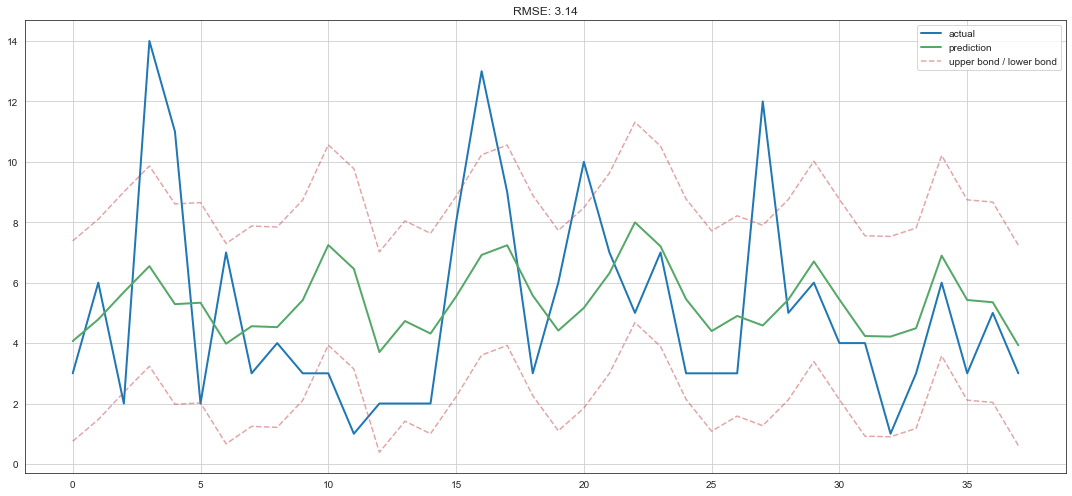

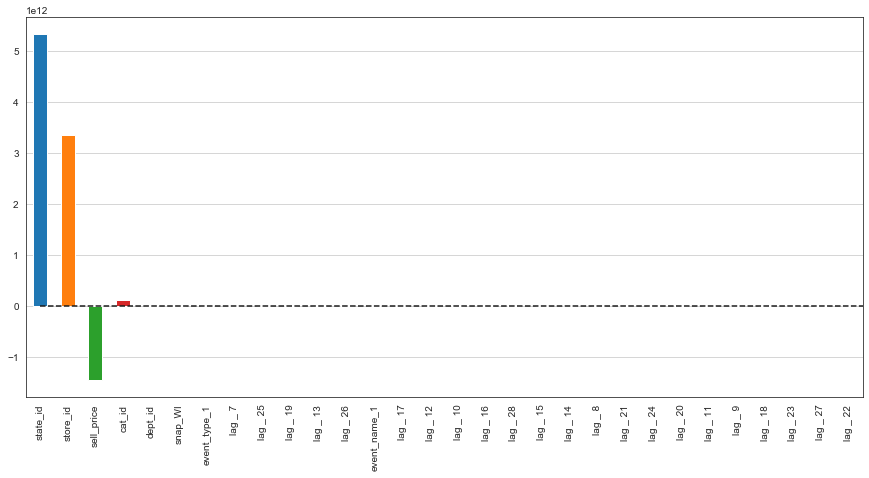

In [62]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

I can see with some simple lags that there are unnecessary features.  I will select features later and engineer some features to improve the performance of the linear regression and other XGBoost regressor.

In [67]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

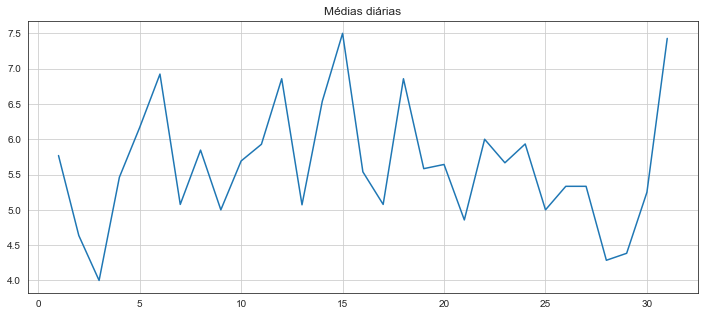

In [68]:
average_day = code_mean(new_df, 'day', "demand")
plt.figure(figsize=(12, 5))
plt.title("Daily Averages")
pd.DataFrame.from_dict(average_day, orient='index')[0].plot()
plt.grid(True);

In [69]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Copy of the initial dataset.
    new_df = df.copy()

    # lags of series
    for i in range(7, 29):
        new_df["lag_{}".format(i)] = new_df['demand'].shift(i)

    # datetime features
    new_df.index = pd.to_datetime(new_df.index)
    new_df["day"] = new_df.index.day
    new_df["weekday"] = new_df.index.weekday
    new_df['is_weekend'] = new_df.weekday.isin([5,6])*1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(new_df.dropna())*(1-test_size))
        new_df['weekday_average'] = list(map(code_mean(new_df[:test_index], 'weekday', "demand").get, new_df['weekday']))
        new_df["day_average"] = list(map(code_mean(new_df[:test_index], 'day', "demand").get, new_df['day']))

        # frop encoded variables 
        new_df.drop(["day", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = new_df.dropna()['demand']
    X = new_df.dropna().drop(['demand'], axis=1)

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

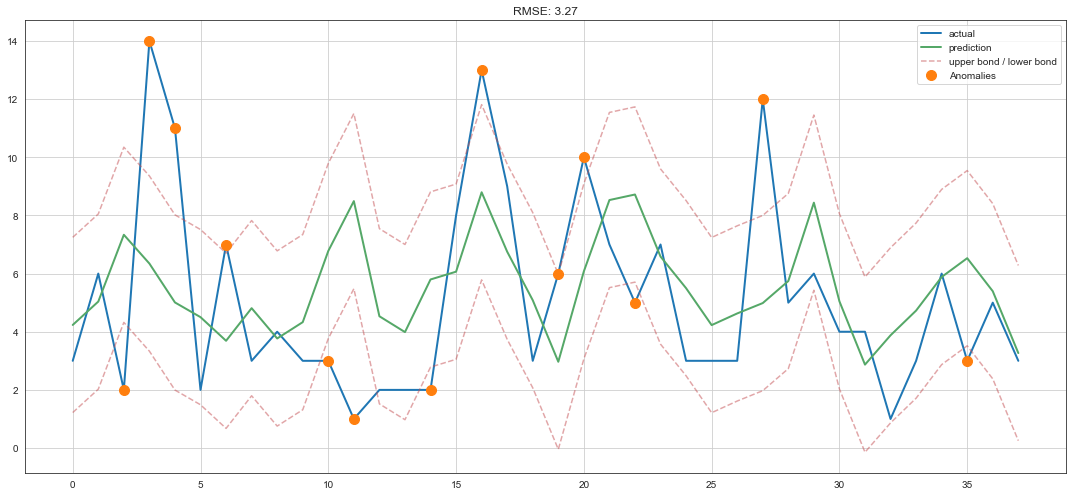

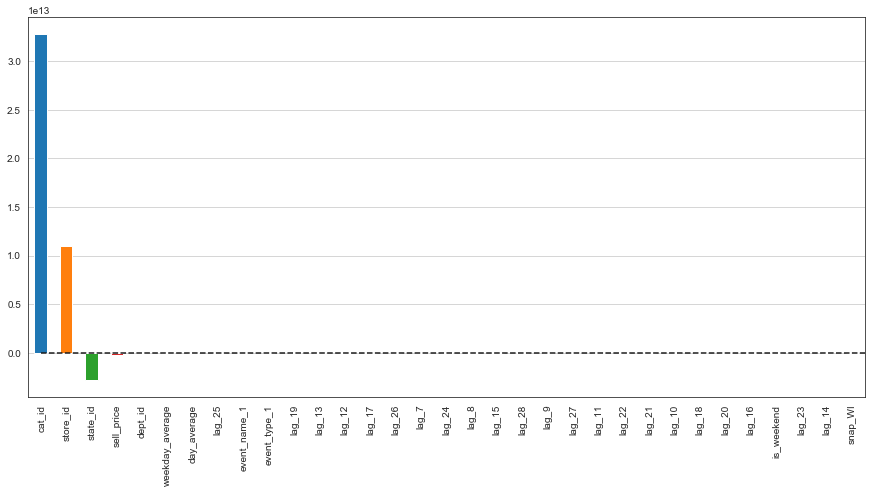

In [70]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

The RMSE increased after feature engineering and encoding.  The model is overfitting the data, so I need to use some regularization techniques for linear regression to correct the overfitting.  I will also select features to help improve the model's performance. 

In [71]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Regularization & Feature Selection

Retrieved from: mlcourse.ai

Not all features are equally important - some can lead to overfitting, while others must be removed. In addition to manual inspection, regularization can be applied. Two of the most popular regression models with regularization are the Ridge and Lasso regressions. Both add some more restrictions to our loss function.

In the case of Ridge regression, these restrictions are the sum of the squares of the coefficients multiplied by the smoothing coefficient. The higher the coefficient of a feature, the greater our loss. Therefore, we will try to optimize the model, keeping the coefficients reasonably low.

As a result of this regularization of L2, we will have a higher bias and less variation, so that the model generalizes better.

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values of the coefficients. As a result, the coefficients of unimportant features become zeros, which allows automated selection of resources. This type of regularization is called L1.

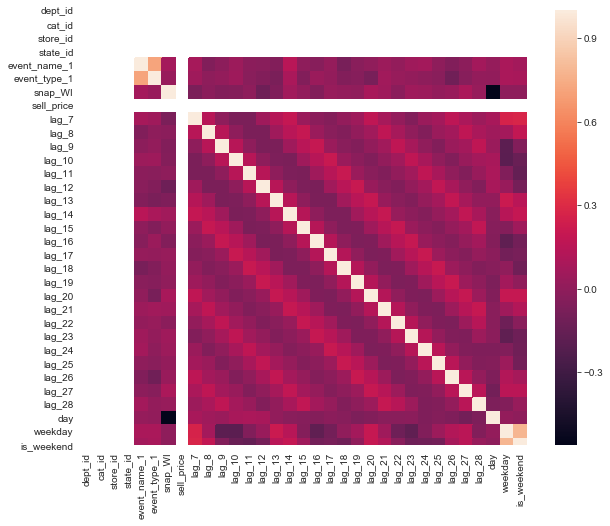

In [72]:
# Check training data for multicollinearity.
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

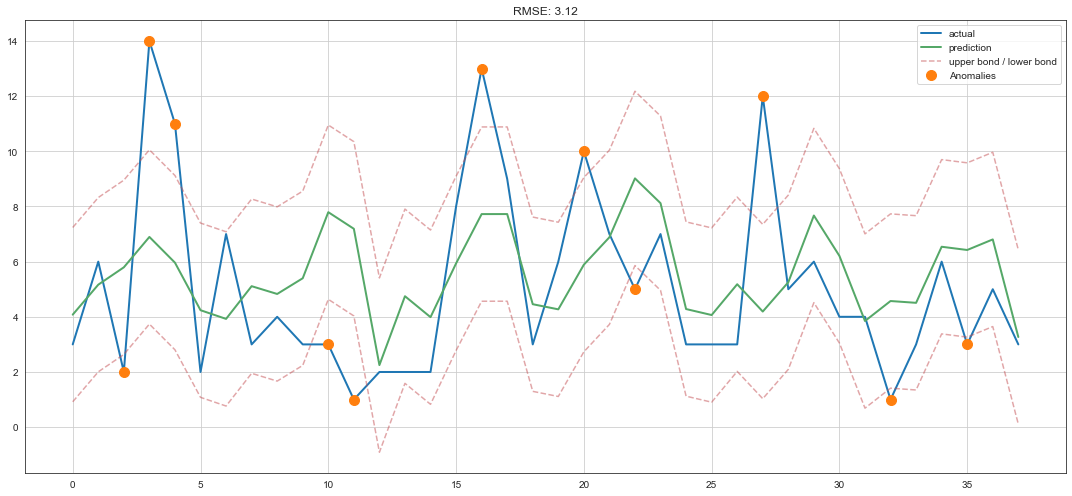

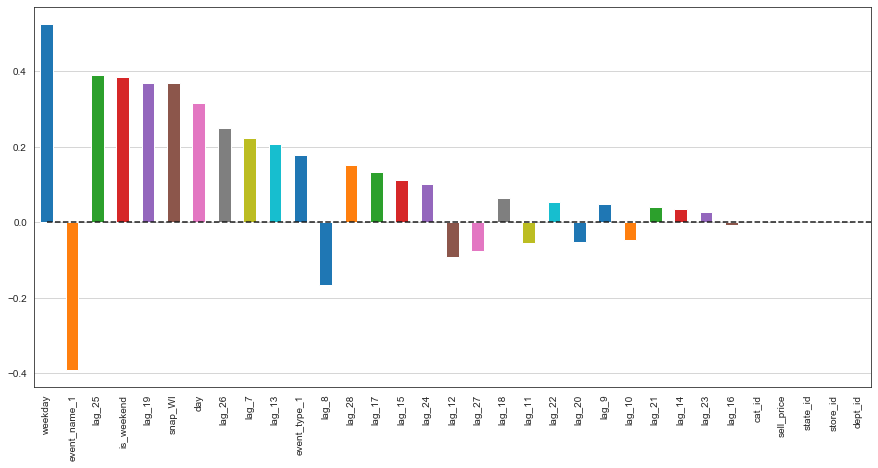

In [73]:
# Ridge Regression.
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(ridge)

I can see some of the coefficients are moving closer to zero but never reach it as their importance in the model decreases.

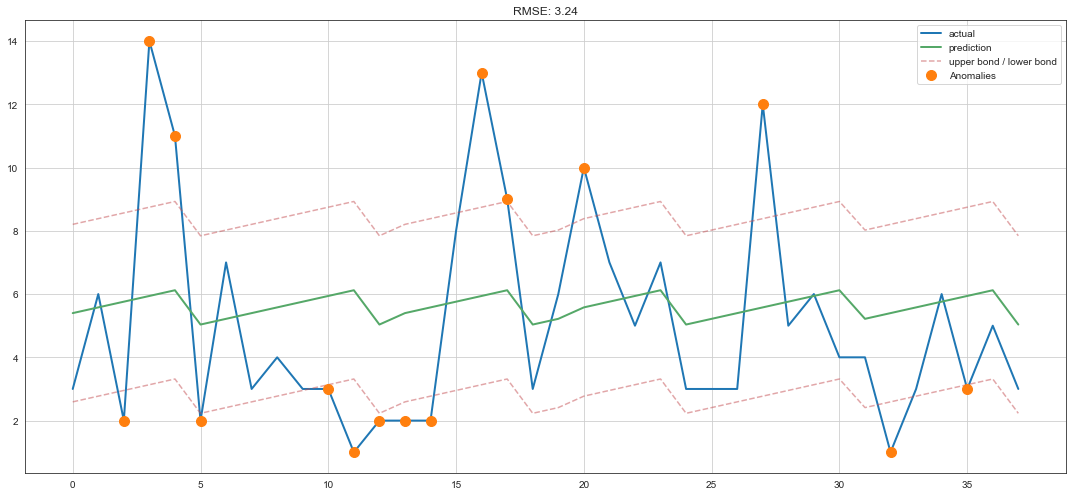

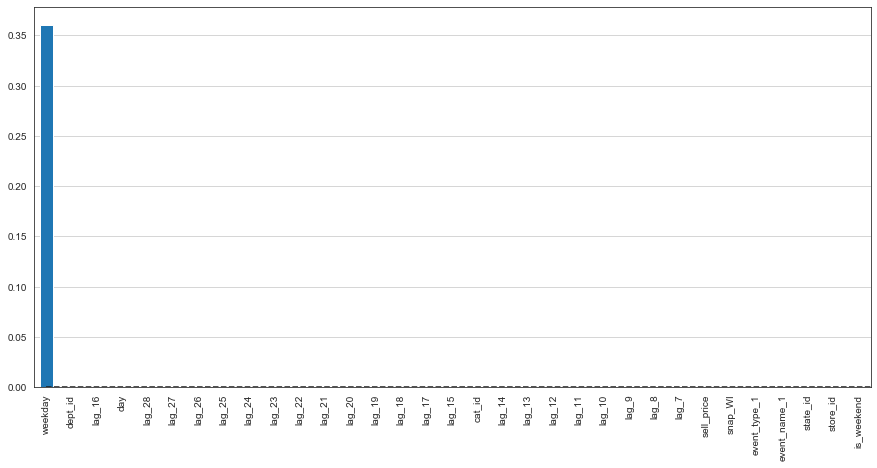

In [74]:
# Lasso Regression for feature selection.
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(lasso)

The Lasso regression removed some of the important lag features which lead to woresen the performance to a RMSE of 3.24.  I do not think I needed to use Lasso Regression due to decreasing the performance of the model.

### XGBoost Regressor

In [75]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

[14:40:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

[14:40:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:40:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:40:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:40:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:40:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


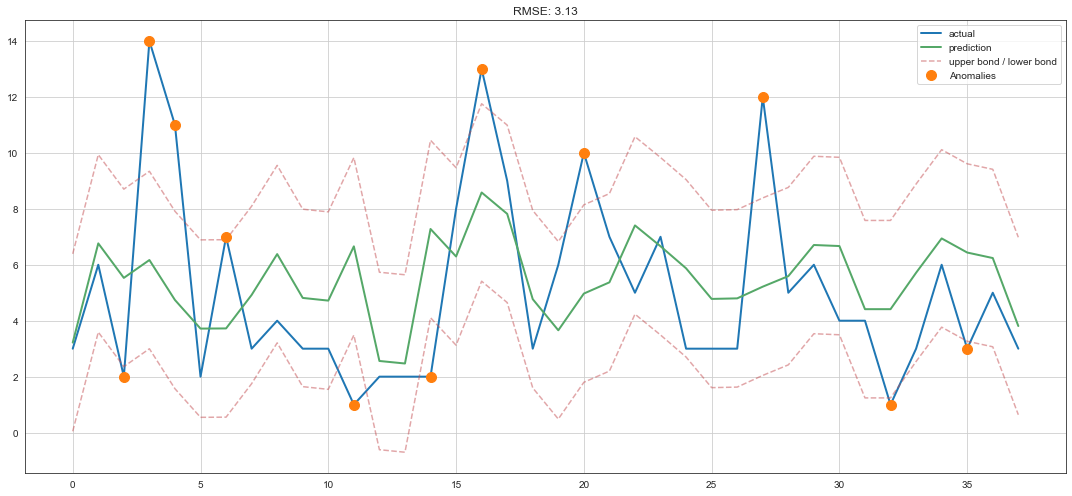

In [76]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)

# Conclusion

After all of the analysis, the ridge regression performed the best.  I think this is due to the feature engineering and transformation of the features.